In [1]:
import sys
sys.path.append('../implementation')
import numpy as np
import pandas as pd
import ast
from tqdm import tqdm
from util import lognormpdf
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sp
import scipy.stats as stats
import time
from statistics import mean
import warnings
import seaborn as sns
import scikit_posthocs as sci_post
import plotly.express as px
import plotly.colors
import random
#warnings.filterwarnings('ignore')

# NCP Results

In [2]:
# Load results
boardrooms_underlying_data = pd.read_csv('../data/boardrooms/boardrooms_data.csv')
political_underlying_data = pd.read_csv('../data/wall/gender/political.csv')
stl_underlying_data = pd.read_csv('../data/stl_crimes/dots.csv')
vast_underlying_data = pd.read_pickle('../data/vast_2011_challenge/vast_data_sample_reduced.pkl')
political_interaction_data = pd.read_csv('../data/wall/gender/wall_political_interactions.csv')

boardrooms_count = len(boardrooms_underlying_data.index)
political_count = len(political_underlying_data.index)
stl_count = len(stl_underlying_data.index)
vast_count = len(vast_underlying_data.index)

stl_map_results_hmm = pd.read_pickle('../output/stl/stl_map_results_hmm.pkl')
stl_map_results_cm = pd.read_pickle('../output/stl/stl_map_results_competing_models.pkl')
stl_map_results_wall = pd.read_pickle('../output/stl/stl_map_results_wall.pkl')
stl_map_results_knn = pd.read_pickle('../output/stl/stl_map_results_knn_uniform_weight.pkl')
stl_map_results_ac = pd.read_pickle('../output/stl/stl_map_results_ac.pkl')
stl_map_results_af = pd.read_pickle('../output/stl/stl_map_results_af.pkl')
stl_map_results_ada = pd.read_pickle('../output/stl/stl_map_results_ada_nb.pkl')
stl_map_results_ensemble = pd.read_pickle('../output/stl/stl_map_results_ensemble.pkl')
stl_map_results_ensemble_bias = pd.read_pickle('../output/stl/stl_map_results_ensemble_bias.pkl')

vast_results_hmm = pd.read_pickle('../output/vast/vast_11_hmm.pkl')
vast_results_cm = pd.read_pickle('../output/vast/vast_11_cm.pkl')
vast_results_wall = pd.read_pickle('../output/vast/vast_11_wall.pkl')
vast_results_knn = pd.read_pickle('../output/vast/vast_11_knn.pkl')
vast_results_ac = pd.read_pickle('../output/vast/vast_11_ac.pkl')
vast_results_af = pd.read_pickle('../output/vast/vast_11_af.pkl')
vast_results_ada = pd.read_pickle('../output/vast/vast_11_ada_nb.pkl')
vast_results_ensemble = pd.read_pickle('../output/vast/vast_11_ensemble.pkl')

boardrooms_results_hmm = pd.read_pickle('../output/boardrooms/boardrooms_hmm.pkl')
boardrooms_results_cm = pd.read_pickle('../output/boardrooms/boardrooms_cm.pkl')
boardrooms_results_wall = pd.read_pickle('../output/boardrooms/boardrooms_wall.pkl')
boardrooms_results_knn = pd.read_pickle('../output/boardrooms/boardrooms_knn.pkl')
boardrooms_results_ac = pd.read_pickle('../output/boardrooms/boardrooms_ac.pkl')
boardrooms_results_af = pd.read_pickle('../output/boardrooms/boardrooms_af.pkl')
boardrooms_results_ada = pd.read_pickle('../output/boardrooms/boardrooms_ada_nb.pkl')
boardrooms_results_ensemble = pd.read_pickle('../output/boardrooms/boardrooms_ensemble.pkl')

political_results_hmm = pd.read_pickle('../output/political/political_hmm.pkl')
political_results_cm = pd.read_pickle('../output/political/political_cm.pkl')
political_results_wall = pd.read_pickle('../output/political/political_wall.pkl')
political_results_knn = pd.read_pickle('../output/political/political_knn.pkl')
political_results_ac = pd.read_pickle('../output/political/political_ac.pkl')
political_results_af = pd.read_pickle('../output/political/political_af.pkl')
political_results_ada = pd.read_pickle('../output/political/political_ada_nb.pkl')
political_results_ensemble = pd.read_pickle('../output/political/political_ensemble.pkl')
political_results_ensemble_bias = pd.read_pickle('../output/political/political_ensemble_bias.pkl')

ks = [1, 5, 10, 20, 50, 100]

0.9114814576881399
0.9285019328497589
0.977192947768078


<ipython-input-16-438efaf7eaf1>:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[ai].set_xticklabels([None] + ks)
<ipython-input-16-438efaf7eaf1>:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[ai].set_xticklabels([None] + ks)
<ipython-input-16-438efaf7eaf1>:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[ai].set_xticklabels([None] + ks)


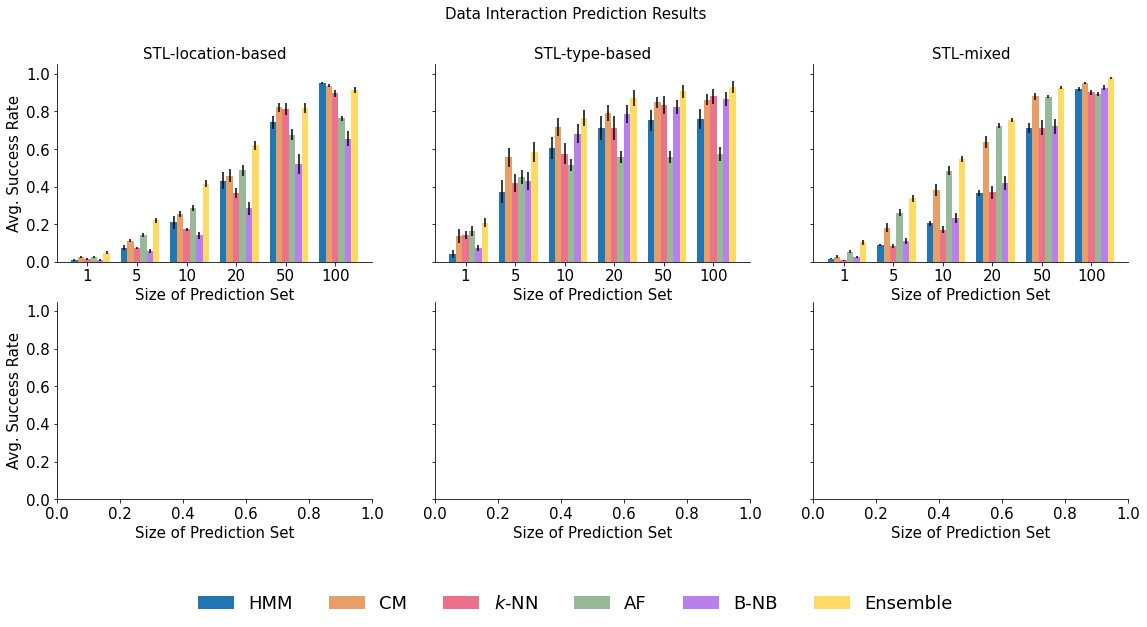

In [16]:
# Comparing next click prediction with Competing Models and HMM
num_rows = 2
num_cols = 3

fig, axs = plt.subplots(num_rows, num_cols, sharey=True, figsize=(num_cols*6.4, num_rows*4))
axs = axs.ravel()
fig.suptitle('Data Interaction Prediction Results', fontsize=15)
plt.rcParams.update({'axes.titlesize': 15, 'axes.labelsize': 15, 'xtick.labelsize':15, 'ytick.labelsize':15})

for i, ax in enumerate(axs):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.set_ylim((0, 1.05))
    ax.set(xlabel='Size of Prediction Set')
#     ax.tick_params(axis='y', which='minor', labelsize=15)
    if i%num_cols == 0:
        ax.set(ylabel='Avg. Success Rate')
    
labels = ['ncp-1','ncp-5','ncp-10','ncp-20','ncp-50','ncp-100']
# labels = ['ncp-1%','ncp-2%','ncp-3%','ncp-4%','ncp-5%']
x = np.arange(len(labels))  # the label locations
width = 0.13  # the width of the bars
for ai, t in enumerate(['geo-based', 'type-based', 'mixed']):
    df_temp_hmm = stl_map_results_hmm[stl_map_results_hmm.task == t][[f'ncp-{k}' for k in ks]]
    err_hmm = df_temp_hmm.std() / np.sqrt(len(df_temp_hmm))
    df_temp_cm = stl_map_results_cm[stl_map_results_cm.task == t][[f'ncp-{k}' for k in ks]]
    err_cm = df_temp_cm.std() / np.sqrt(len(df_temp_cm))
    df_temp_knn = stl_map_results_knn[stl_map_results_knn.task == t][[f'ncp-{k}' for k in ks]]
    err_knn = df_temp_knn.std() / np.sqrt(len(df_temp_knn))
    df_temp_af = stl_map_results_af[stl_map_results_af.task == t][[f'ncp-{k}' for k in ks]]
    err_af = df_temp_af.std() / np.sqrt(len(df_temp_af))
    df_temp_ada = stl_map_results_ada[stl_map_results_ada.task == t][[f'ncp-{k}' for k in ks]]
    err_ada = df_temp_ada.std() / np.sqrt(len(df_temp_ada))
    df_temp_ensemble = stl_map_results_ensemble[stl_map_results_ensemble.task == t][[f'ncp-{k}' for k in ks]]
    err_ensemble = df_temp_ensemble.std() / np.sqrt(len(df_temp_ensemble))
    
    hmm_results = df_temp_hmm.mean().to_numpy()
    cm_results = df_temp_cm.mean().to_numpy()
    knn_results = df_temp_knn.mean().to_numpy()
    af_results = df_temp_af.mean().to_numpy()
    ada_results = df_temp_ada.mean().to_numpy()
    ensemble_results = df_temp_ensemble.mean().to_numpy()
    
    print(ensemble_results[5])
    hmm_bar = axs[ai].bar(x - width*2, hmm_results, width, label='HMM', yerr=err_hmm, color='#2077B4')
    cm_bar = axs[ai].bar(x - width, cm_results, width, label='CM', yerr=err_cm, color='#d95f02', alpha=0.6)
    knn_bar = axs[ai].bar(x, knn_results, width, label='$k$-NN', yerr=err_knn, color='#DC143C', alpha=0.6)
    af_bar = axs[ai].bar(x + width, af_results, width, label='AF', yerr=err_af, color='#548B54', alpha=0.6)
    ada_bar = axs[ai].bar(x + width*2, ada_results, width, label='B-NB', yerr=err_ada, color='#8A2BE2', alpha=0.6)
    ensemble_bar = axs[ai].bar(x + width*3, ensemble_results, width, label='Ensemble', yerr=err_ensemble, color='#FFC400', alpha=0.6)
    
    
    axs[ai].set_title(f'STL-{t.replace("geo", "location")}')
    axs[ai].set_xticklabels([None] + ks)
    
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=6, fontsize=18, fancybox=False, frameon=False)

In [17]:
# Vast Barcharts added
ax = axs[3]

df_temp_hmm = vast_results_hmm[[f'ncp-{k}' for k in ks]]
err_hmm = df_temp_hmm.std() / np.sqrt(len(df_temp_hmm))
df_temp_cm = vast_results_cm[[f'ncp-{k}' for k in ks]]
err_cm = df_temp_cm.std() / np.sqrt(len(df_temp_cm))
df_temp_knn = vast_results_knn[[f'ncp-{k}' for k in ks]]
err_knn = df_temp_knn.std() / np.sqrt(len(df_temp_knn))
df_temp_af = vast_results_af[[f'ncp-{k}' for k in ks]]
err_af = df_temp_af.std() / np.sqrt(len(df_temp_af))
df_temp_ada = vast_results_ada[[f'ncp-{k}' for k in ks]]
err_ada = df_temp_ada.std() / np.sqrt(len(df_temp_ada))
df_temp_ensemble = vast_results_ensemble[[f'ncp-{k}' for k in ks]]
err_ensemble = df_temp_ensemble.std() / np.sqrt(len(df_temp_ensemble))

hmm_results = df_temp_hmm.mean()
cm_results = df_temp_cm.mean()
knn_results = df_temp_knn.mean()
af_results = df_temp_af.mean()
ada_results = df_temp_ada.mean()
ensemble_results = df_temp_ensemble.mean()

print(ensemble_results[5])

hmm_bar = ax.bar(x - width*2, hmm_results, width, label='HMM', yerr=err_hmm, color='#2077B4')
cm_bar = ax.bar(x - width, cm_results, width, label='Competing Models', yerr=err_cm, color='#d95f02', alpha=0.6)
knn_bar = ax.bar(x, knn_results, width, label='$k$-NN', yerr=err_knn, color='#DC143C', alpha=0.6)
af_bar = ax.bar(x + width, af_results, width, label='Analytic Focus', yerr=err_af, color='#548B54', alpha=0.6)
ada_bar = ax.bar(x + width*2, ada_results, width, label='Boosted-NB', yerr=err_ada, color='#8A2BE2', alpha=0.6)
ensemble_bar = ax.bar(x + width*3, ensemble_results, width, label='Ensemble', yerr=err_ensemble, color='#FFC400', alpha=0.6)

ax.set_title('Vastopolis')
ax.set_xticklabels([None] + ks)

0.4651207125640132


<ipython-input-17-fd241cbfd5dd>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([None] + ks)


[Text(-1.0, 0, ''),
 Text(0.0, 0, '1'),
 Text(1.0, 0, '5'),
 Text(2.0, 0, '10'),
 Text(3.0, 0, '20'),
 Text(4.0, 0, '50'),
 Text(5.0, 0, '100'),
 Text(6.0, 0, '')]

0.4902734954845365


<ipython-input-18-f1d0c3046e54>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([None] + ks)


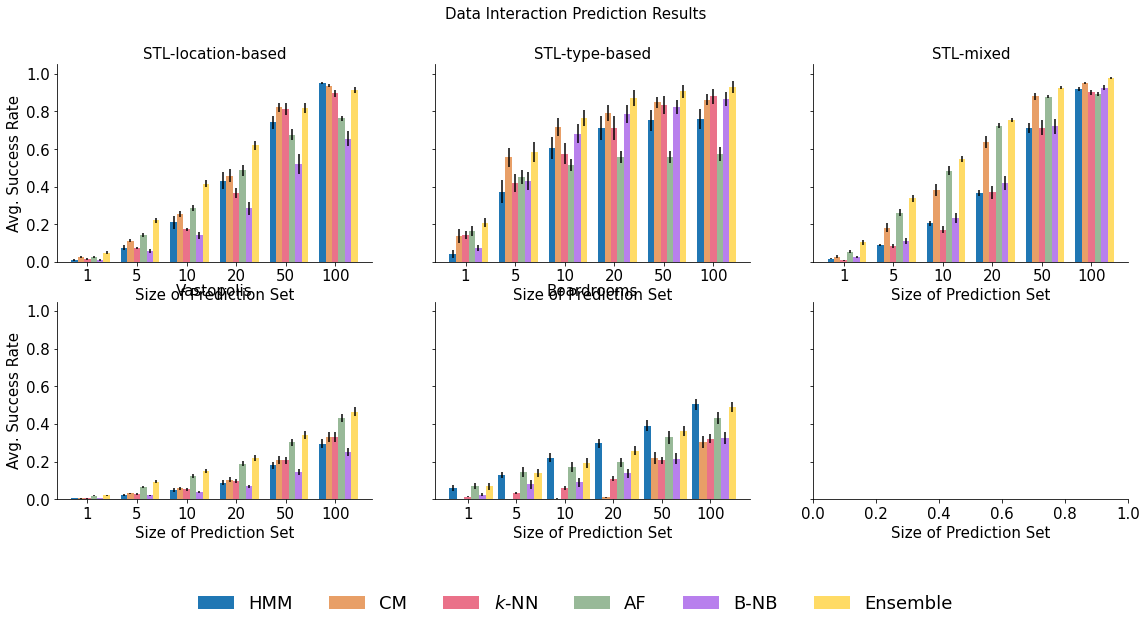

In [18]:
# For boardrooms data
ax = axs[4]
width = 0.15  # the width of the bars
t = 1
df_temp_hmm = boardrooms_results_hmm[boardrooms_results_hmm.task == t][[f'ncp-{k}' for k in ks]]
err_hmm = df_temp_hmm.std() / np.sqrt(len(df_temp_hmm))
df_temp_cm = boardrooms_results_cm[boardrooms_results_cm.task == t][[f'ncp-{k}' for k in ks]]
err_cm = df_temp_cm.std() / np.sqrt(len(df_temp_cm))
df_temp_knn = boardrooms_results_knn[boardrooms_results_knn.task == t][[f'ncp-{k}' for k in ks]]
err_knn = df_temp_knn.std() / np.sqrt(len(df_temp_knn))
df_temp_af = boardrooms_results_af[boardrooms_results_af.task == t][[f'ncp-{k}' for k in ks]]
err_af = df_temp_af.std() / np.sqrt(len(df_temp_af))
df_temp_ada = boardrooms_results_ada[boardrooms_results_ada.task == t][[f'ncp-{k}' for k in ks]]
err_ada = df_temp_ada.std() / np.sqrt(len(df_temp_ada))
df_temp_ensemble = boardrooms_results_ensemble[boardrooms_results_ensemble.task == t][[f'ncp-{k}' for k in ks]]
err_ensemble = df_temp_ensemble.std() / np.sqrt(len(df_temp_ensemble))

hmm_results = df_temp_hmm.mean()
cm_results = df_temp_cm.mean()
knn_results = df_temp_knn.mean()
af_results = df_temp_af.mean()
ada_results = df_temp_ada.mean()
ensemble_results = df_temp_ensemble.mean()

print(ensemble_results[5])

hmm_bar = ax.bar(x - width*2, hmm_results, width, label='HMM', yerr=err_hmm, color='#2077B4')
cm_bar = ax.bar(x - width, cm_results, width, label='Competing Models', yerr=err_cm, color='#d95f02', alpha=0.6)
knn_bar = ax.bar(x, knn_results, width, label='KNN', yerr=err_knn, color='#DC143C', alpha=0.6)
af_bar = ax.bar(x + width, af_results, width, label='Analytic Focus', yerr=err_af, color='#548B54', alpha=0.6)
ada_bar = ax.bar(x + width*2, ada_results, width, label='AdaBoost-NB', yerr=err_ada, color='#8A2BE2', alpha=0.6)
ensemble_bar = ax.bar(x + width*3, ensemble_results, width, label='Ensemble', yerr=err_ensemble, color='#FFC400', alpha=0.6)

ax.set_title('Boardrooms')
ax.set_xticklabels([None] + ks)
fig

0.5266280016280016


<ipython-input-19-caa309da84e9>:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([None] + ks)


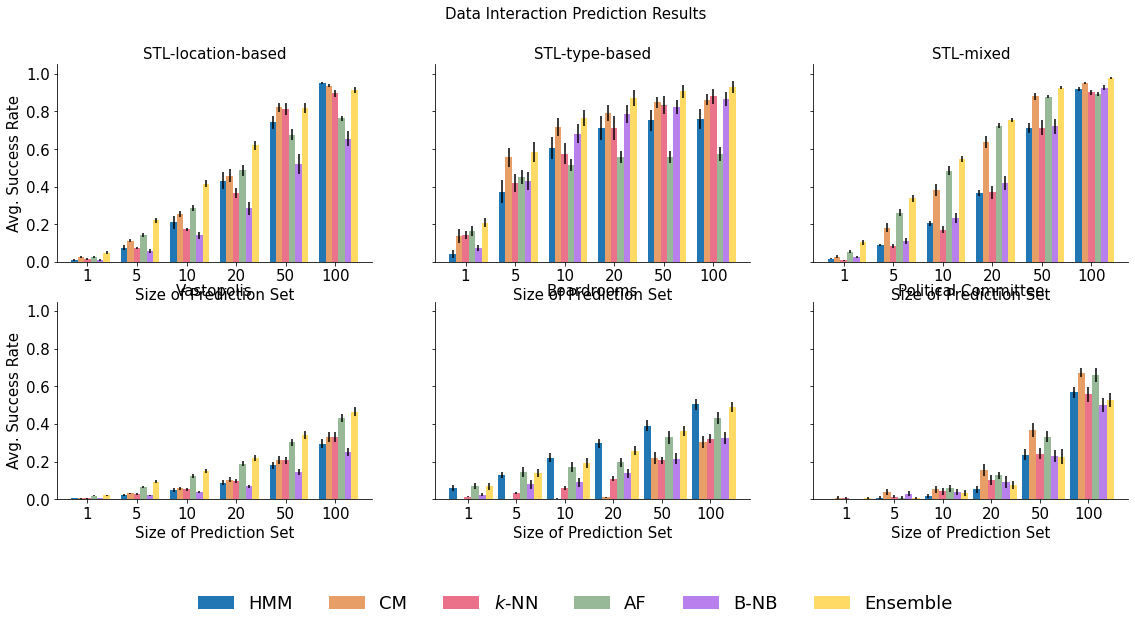

In [19]:
ax = axs[5]
width = 0.15  # the width of the bars
title = 'Political Committee'
df_temp_hmm = political_results_hmm[[f'ncp-{k}' for k in ks]]
err_hmm = df_temp_hmm.std() / np.sqrt(len(df_temp_hmm))
df_temp_cm = political_results_cm[[f'ncp-{k}' for k in ks]]
err_cm = df_temp_cm.std() / np.sqrt(len(df_temp_cm))
df_temp_knn = political_results_knn[[f'ncp-{k}' for k in ks]]
err_knn = df_temp_knn.std() / np.sqrt(len(df_temp_knn))
df_temp_af = political_results_af[[f'ncp-{k}' for k in ks]]
err_af = df_temp_af.std() / np.sqrt(len(df_temp_af))
df_temp_ada = political_results_ada[[f'ncp-{k}' for k in ks]]
err_ada = df_temp_ada.std() / np.sqrt(len(df_temp_ada))
df_temp_ensemble = political_results_ensemble[[f'ncp-{k}' for k in ks]]
err_ensemble = df_temp_ensemble.std() / np.sqrt(len(df_temp_ensemble))

# df_temp_hmm = movies_results_hmm[[f'perc-ncp-{k}' for k in movies_ks]]
# err_hmm = df_temp_hmm.std() / np.sqrt(len(df_temp_hmm))
# df_temp_cm = movies_results_cm[[f'perc-ncp-{k}' for k in movies_ks]]
# err_cm = df_temp_cm.std() / np.sqrt(len(df_temp_cm))
# df_temp_knn = movies_results_knn[[f'perc-ncp-{k}' for k in movies_ks]]
# err_knn = df_temp_knn.std() / np.sqrt(len(df_temp_knn))
# df_temp_af = movies_results_af[[f'perc-ncp-{k}' for k in movies_ks]]
# err_af = df_temp_af.std() / np.sqrt(len(df_temp_af))
# df_temp_ada = movies_results_ada[[f'perc-ncp-{k}' for k in movies_ks]]
# err_ada = df_temp_ada.std() / np.sqrt(len(df_temp_ada))

hmm_results = df_temp_hmm.mean()
cm_results = df_temp_cm.mean()
knn_results = df_temp_knn.mean()
af_results = df_temp_af.mean()
ada_results = df_temp_ada.mean()
ensemble_results = df_temp_ensemble.mean()

print(ensemble_results[5])

hmm_bar = ax.bar(x - width*2, hmm_results, width, label='HMM', yerr=err_hmm, color='#2077B4')
cm_bar = ax.bar(x - width, cm_results, width, label='Competing Models', yerr=err_cm, color='#d95f02', alpha=0.6)
knn_bar = ax.bar(x, knn_results, width, label='KNN', yerr=err_knn, color='#DC143C', alpha=0.6)
af_bar = ax.bar(x + width, af_results, width, label='Analytic Focus', yerr=err_af, color='#548B54', alpha=0.6)
ada_bar = ax.bar(x + width*2, ada_results, width, label='AdaBoost-NB', yerr=err_ada, color='#8A2BE2', alpha=0.6)
ensemble_bar = ax.bar(x + width*3, ensemble_results, width, label='Ensemble', yerr=err_ensemble, color='#FFC400', alpha=0.6)

ax.set_title(title)
ax.set_xticklabels([None] + ks)
fig

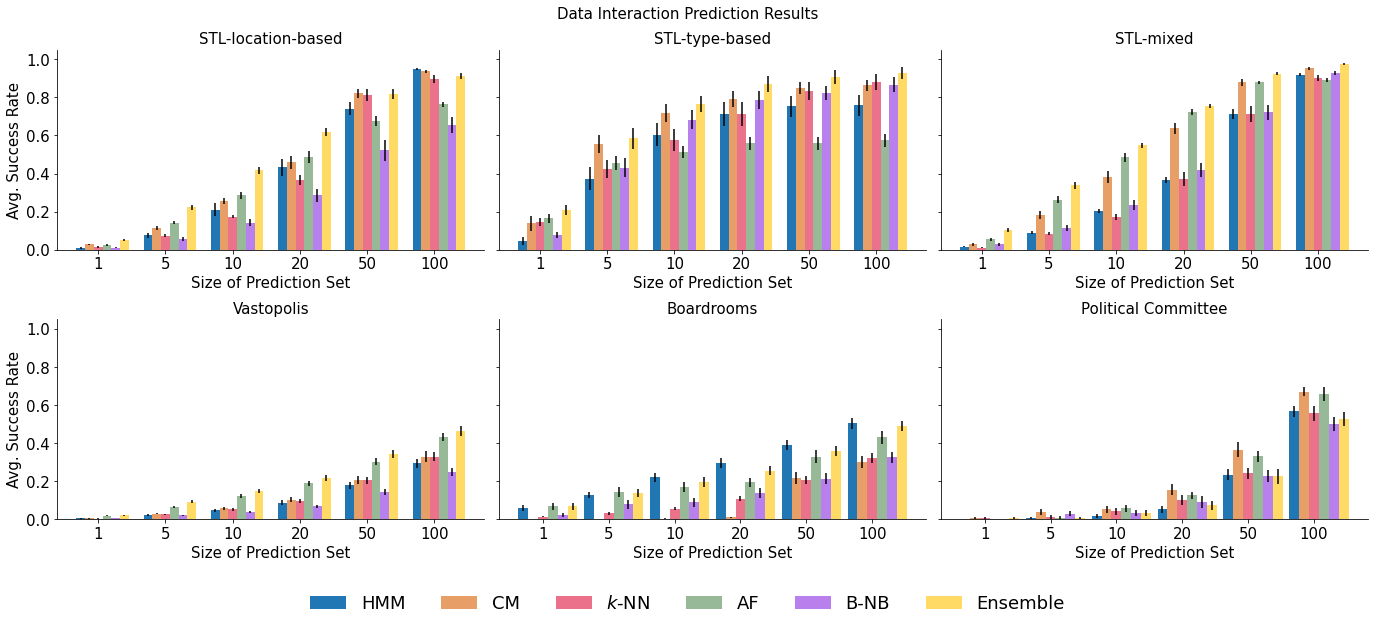

In [20]:
fig.tight_layout()
fig.savefig('../output/figs/ncp_results.png', dpi=300, bbox_inches='tight')
fig

# Next Interaction Ranking Plots

In [8]:
avg_rank = pd.DataFrame()

for ai, t in enumerate(['geo-based', 'type-based', 'mixed']):
    for i, row in stl_map_results_hmm[stl_map_results_hmm.task == t].iterrows():
        average_rank = mean(row['rank'])
        average_rank_perc = (average_rank/stl_count) * 100
        temp_df = pd.DataFrame({'alg': ['hmm'], 'task': [t], 'average_rank': [average_rank], 'average_rank_perc': [average_rank_perc]})
        avg_rank = pd.concat([avg_rank, temp_df], ignore_index=True)
    for i, row in stl_map_results_cm[stl_map_results_cm.task == t].iterrows():
        average_rank = mean(row['rank'])
        average_rank_perc = (average_rank/stl_count) * 100
        temp_df = pd.DataFrame({'alg': ['cm'], 'task': [t], 'average_rank': [average_rank], 'average_rank_perc': [average_rank_perc]})
        avg_rank = pd.concat([avg_rank, temp_df], ignore_index=True)
    for i, row in stl_map_results_af[stl_map_results_af.task == t].iterrows():
        average_rank = mean(row['rank'])
        average_rank_perc = (average_rank/stl_count) * 100
        temp_df = pd.DataFrame({'alg': ['af'], 'task': [t], 'average_rank': [average_rank], 'average_rank_perc': [average_rank_perc]})
        avg_rank = pd.concat([avg_rank, temp_df], ignore_index=True)
    for i, row in stl_map_results_knn[stl_map_results_knn.task == t].iterrows():
        average_rank = mean(row['rank'])
        average_rank_perc = (average_rank/stl_count) * 100
        temp_df = pd.DataFrame({'alg': ['knn'], 'task': [t], 'average_rank': [average_rank], 'average_rank_perc': [average_rank_perc]})
        avg_rank = pd.concat([avg_rank, temp_df], ignore_index=True)
    for i, row in stl_map_results_ada[stl_map_results_ada.task == t].iterrows():
        average_rank = mean(row['rank'])
        average_rank_perc = (average_rank/stl_count) * 100
        temp_df = pd.DataFrame({'alg': ['ada_nb'], 'task': [t], 'average_rank': [average_rank], 'average_rank_perc': [average_rank_perc]})
        avg_rank = pd.concat([avg_rank, temp_df], ignore_index=True)
    for i, row in stl_map_results_ensemble[stl_map_results_ensemble.task == t].iterrows():
        average_rank = mean(row['rank'])
        average_rank_perc = (average_rank/stl_count) * 100
        temp_df = pd.DataFrame({'alg': ['ensemble'], 'task': [t], 'average_rank': [average_rank], 'average_rank_perc': [average_rank_perc]})
        avg_rank = pd.concat([avg_rank, temp_df], ignore_index=True)

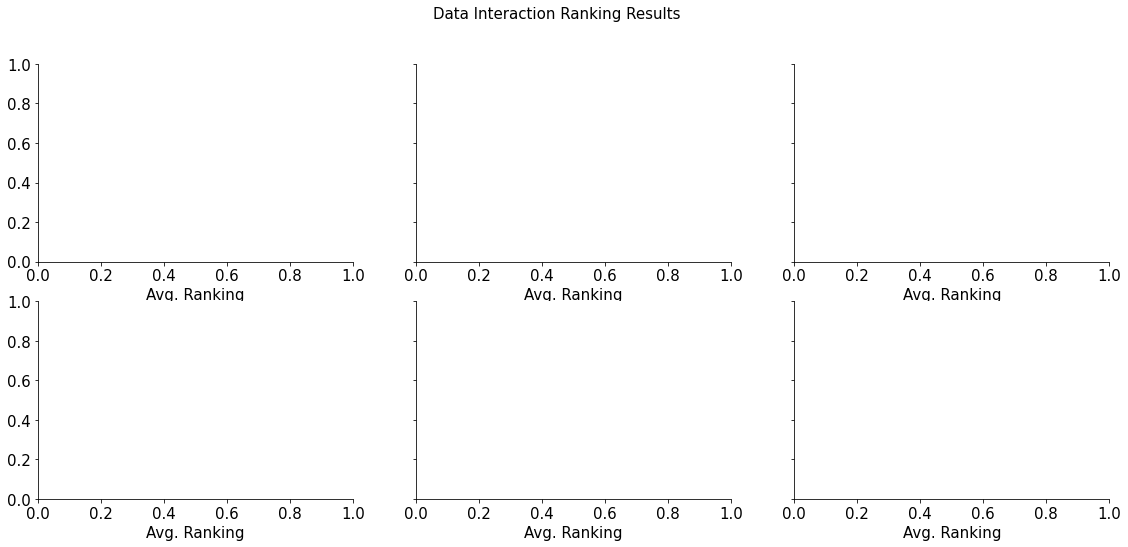

In [9]:
num_rows = 2
num_cols = 3

fig, axs = plt.subplots(num_rows, num_cols, sharey=True, figsize=(num_cols*6.4, num_rows*4))
axs = axs.ravel()
fig.suptitle('Data Interaction Ranking Results', fontsize=15)
plt.rcParams.update({'axes.titlesize': 15, 'axes.labelsize': 15, 'xtick.labelsize':15})
for i, ax in enumerate(axs):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.set(xlabel='Avg. Ranking')
    #ax.set_ylim((0, 1.05))

In [10]:
techniques_colors = {
    'hmm': ('#2077B4', 'HMM'), 
    'cm': ('#E89F67', 'CM'),
    'ada_nb': ('#B880ED', 'B-NB'), 
    'af': ('#98B998', 'AF'),
    'knn': ('#EA728A', '$k$-NN'),
    'ensemble': ('#FFDB65','Ensemble')
}

medianprops = dict(linestyle='-', linewidth=2.5, color='black')

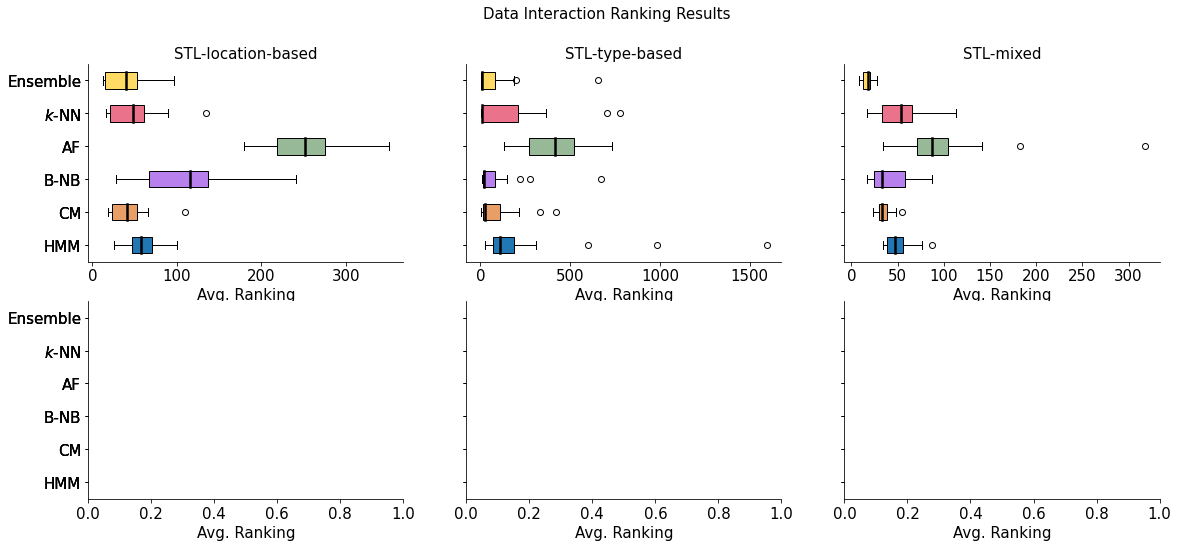

In [11]:
# STL geobased
ax = axs[0]
df_temp = avg_rank[avg_rank.task=='geo-based']
ax.set_title('STL-location-based')
ax.tick_params(axis='y', which='minor', labelsize=15)
for i, alg in enumerate(techniques_colors):
    bar = ax.boxplot(df_temp.loc[df_temp.alg==alg, 'average_rank'].to_numpy(), positions = [i], vert=False, patch_artist=True, labels=[techniques_colors[alg][1]], widths=[0.5], medianprops=medianprops)
    bar['boxes'][0].set_facecolor(techniques_colors[alg][0])
    
    
# STL typebased
ax = axs[1]
df_temp = avg_rank[avg_rank.task=='type-based']
ax.set_title('STL-type-based')
for i, alg in enumerate(techniques_colors):
    bar = ax.boxplot(df_temp.loc[df_temp.alg==alg, 'average_rank'].to_numpy(), positions = [i], vert=False, patch_artist=True, labels=[techniques_colors[alg][1]], widths=[0.5], medianprops=medianprops)
    bar['boxes'][0].set_facecolor(techniques_colors[alg][0])
    

# STL mixed
ax = axs[2]
df_temp = avg_rank[avg_rank.task=='mixed']
ax.set_title('STL-mixed')
for i, alg in enumerate(techniques_colors):
    bar = ax.boxplot(df_temp.loc[df_temp.alg==alg, 'average_rank'].to_numpy(), positions = [i], vert=False, patch_artist=True, labels=[techniques_colors[alg][1]], widths=[0.5], medianprops=medianprops)
    bar['boxes'][0].set_facecolor(techniques_colors[alg][0])
fig

In [12]:
# Vastopolis

avg_rank = pd.DataFrame()

t = 'control'
for i, row in vast_results_hmm[vast_results_hmm.task == t].iterrows():
    average_rank = mean(row['rank'])
    average_rank_perc = (average_rank/vast_count) * 100
    temp_df = pd.DataFrame({'alg': ['hmm'], 'task': [t], 'average_rank': [average_rank], 'average_rank_perc': [average_rank_perc]})
    avg_rank = pd.concat([avg_rank, temp_df], ignore_index=True)
for i, row in vast_results_cm[vast_results_cm.task == t].iterrows():
    average_rank = mean(row['rank'])
    average_rank_perc = (average_rank/vast_count) * 100
    temp_df = pd.DataFrame({'alg': ['cm'], 'task': [t], 'average_rank': [average_rank], 'average_rank_perc': [average_rank_perc]})
    avg_rank = pd.concat([avg_rank, temp_df], ignore_index=True)
for i, row in vast_results_af[vast_results_af.task == t].iterrows():
    average_rank = mean(row['rank'])
    average_rank_perc = (average_rank/vast_count) * 100
    temp_df = pd.DataFrame({'alg': ['af'], 'task': [t], 'average_rank': [average_rank], 'average_rank_perc': [average_rank_perc]})
    avg_rank = pd.concat([avg_rank, temp_df], ignore_index=True)
for i, row in vast_results_knn[vast_results_knn.task == t].iterrows():
    average_rank = mean(row['rank'])
    average_rank_perc = (average_rank/vast_count) * 100
    temp_df = pd.DataFrame({'alg': ['knn'], 'task': [t], 'average_rank': [average_rank], 'average_rank_perc': [average_rank_perc]})
    avg_rank = pd.concat([avg_rank, temp_df], ignore_index=True)
for i, row in vast_results_ada[vast_results_ada.task == t].iterrows():
    average_rank = mean(row['rank'])
    average_rank_perc = (average_rank/vast_count) * 100
    temp_df = pd.DataFrame({'alg': ['ada_nb'], 'task': [t], 'average_rank': [average_rank], 'average_rank_perc': [average_rank_perc]})
    avg_rank = pd.concat([avg_rank, temp_df], ignore_index=True)
for i, row in vast_results_ensemble[vast_results_ensemble.task == t].iterrows():
    average_rank = mean(row['rank'])
    average_rank_perc = (average_rank/vast_count) * 100
    temp_df = pd.DataFrame({'alg': ['ensemble'], 'task': [t], 'average_rank': [average_rank], 'average_rank_perc': [average_rank_perc]})
    avg_rank = pd.concat([avg_rank, temp_df], ignore_index=True)

ax = axs[3]
df_temp = avg_rank.dropna()
ax.set_title('Vastopolis')
for i, alg in enumerate(techniques_colors):
    bar = ax.boxplot(df_temp.loc[df_temp.alg==alg, 'average_rank'].to_numpy(), positions = [i], vert=False, patch_artist=True, labels=[techniques_colors[alg][1]], widths=[0.5], medianprops=medianprops)
    bar['boxes'][0].set_facecolor(techniques_colors[alg][0])

In [13]:
# boardrooms 

avg_rank = pd.DataFrame()

t = 1
for i, row in boardrooms_results_hmm[boardrooms_results_hmm.task == t].iterrows():
    average_rank = mean(row['rank'])
    average_rank_perc = (average_rank/boardrooms_count) * 100
    temp_df = pd.DataFrame({'alg': ['hmm'], 'task': [t], 'average_rank': [average_rank], 'average_rank_perc': [average_rank_perc]})
    avg_rank = pd.concat([avg_rank, temp_df], ignore_index=True)
for i, row in boardrooms_results_cm[boardrooms_results_cm.task == t].iterrows():
    average_rank = mean(row['rank'])
    average_rank_perc = (average_rank/boardrooms_count) * 100
    temp_df = pd.DataFrame({'alg': ['cm'], 'task': [t], 'average_rank': [average_rank], 'average_rank_perc': [average_rank_perc]})
    avg_rank = pd.concat([avg_rank, temp_df], ignore_index=True)
for i, row in boardrooms_results_af[boardrooms_results_af.task == t].iterrows():
    average_rank = mean(row['rank'])
    average_rank_perc = (average_rank/boardrooms_count) * 100
    temp_df = pd.DataFrame({'alg': ['af'], 'task': [t], 'average_rank': [average_rank], 'average_rank_perc': [average_rank_perc]})
    avg_rank = pd.concat([avg_rank, temp_df], ignore_index=True)
for i, row in boardrooms_results_knn[boardrooms_results_knn.task == t].iterrows():
    average_rank = mean(row['rank'])
    average_rank_perc = (average_rank/boardrooms_count) * 100
    temp_df = pd.DataFrame({'alg': ['knn'], 'task': [t], 'average_rank': [average_rank], 'average_rank_perc': [average_rank_perc]})
    avg_rank = pd.concat([avg_rank, temp_df], ignore_index=True)
for i, row in boardrooms_results_ada[boardrooms_results_ada.task == t].iterrows():
    average_rank = mean(row['rank'])
    average_rank_perc = (average_rank/boardrooms_count) * 100
    temp_df = pd.DataFrame({'alg': ['ada_nb'], 'task': [t], 'average_rank': [average_rank], 'average_rank_perc': [average_rank_perc]})
    avg_rank = pd.concat([avg_rank, temp_df], ignore_index=True)
for i, row in boardrooms_results_ensemble[boardrooms_results_ensemble.task == t].iterrows():
    average_rank = mean(row['rank'])
    average_rank_perc = (average_rank/boardrooms_count) * 100
    temp_df = pd.DataFrame({'alg': ['ensemble'], 'task': [t], 'average_rank': [average_rank], 'average_rank_perc': [average_rank_perc]})
    avg_rank = pd.concat([avg_rank, temp_df], ignore_index=True)
    
ax = axs[4]
df_temp = avg_rank[avg_rank.task==1]
ax.set_title('Boardrooms')
for i, alg in enumerate(techniques_colors):
    bar = ax.boxplot(df_temp.loc[df_temp.alg==alg, 'average_rank'].to_numpy(), positions = [i], vert=False, patch_artist=True, labels=[techniques_colors[alg][1]], widths=[0.5], medianprops=medianprops)
    bar['boxes'][0].set_facecolor(techniques_colors[alg][0])

In [14]:
# political 

avg_rank = pd.DataFrame()
title = 'Political Committee'
for i, row in political_results_hmm.iterrows():
    average_rank = mean(row['rank'])
    average_rank_perc = (average_rank/political_count) * 100
    temp_df = pd.DataFrame({'alg': ['hmm'], 'average_rank': [average_rank], 'average_rank_perc': [average_rank_perc]})
    avg_rank = pd.concat([avg_rank, temp_df], ignore_index=True)
for i, row in political_results_cm.iterrows():
    average_rank = mean(row['rank'])
    average_rank_perc = (average_rank/political_count) * 100
    temp_df = pd.DataFrame({'alg': ['cm'], 'average_rank': [average_rank], 'average_rank_perc': [average_rank_perc]})
    avg_rank = pd.concat([avg_rank, temp_df], ignore_index=True)
for i, row in political_results_af.iterrows():
    average_rank = mean(row['rank'])
    average_rank_perc = (average_rank/political_count) * 100
    temp_df = pd.DataFrame({'alg': ['af'], 'average_rank': [average_rank], 'average_rank_perc': [average_rank_perc]})
    avg_rank = pd.concat([avg_rank, temp_df], ignore_index=True)
for i, row in political_results_knn.iterrows():
    average_rank = mean(row['rank'])
    average_rank_perc = (average_rank/political_count) * 100
    temp_df = pd.DataFrame({'alg': ['knn'], 'average_rank': [average_rank], 'average_rank_perc': [average_rank_perc]})
    avg_rank = pd.concat([avg_rank, temp_df], ignore_index=True)
for i, row in political_results_ada.iterrows():
    average_rank = mean(row['rank'])
    average_rank_perc = (average_rank/political_count) * 100
    temp_df = pd.DataFrame({'alg': ['ada_nb'], 'average_rank': [average_rank], 'average_rank_perc': [average_rank_perc]})
    avg_rank = pd.concat([avg_rank, temp_df], ignore_index=True)
for i, row in political_results_ensemble.iterrows():
    average_rank = mean(row['rank'])
    average_rank_perc = (average_rank/political_count) * 100
    temp_df = pd.DataFrame({'alg': ['ensemble'], 'average_rank': [average_rank], 'average_rank_perc': [average_rank_perc]})
    avg_rank = pd.concat([avg_rank, temp_df], ignore_index=True)


ax = axs[5]
ax.set_title(title)
for i, alg in enumerate(techniques_colors):
    bar = ax.boxplot(avg_rank.loc[avg_rank.alg==alg, 'average_rank'].to_numpy(), positions = [i], vert=False, patch_artist=True, labels=[techniques_colors[alg][1]], widths=[0.5], medianprops=medianprops)
    bar['boxes'][0].set_facecolor(techniques_colors[alg][0])

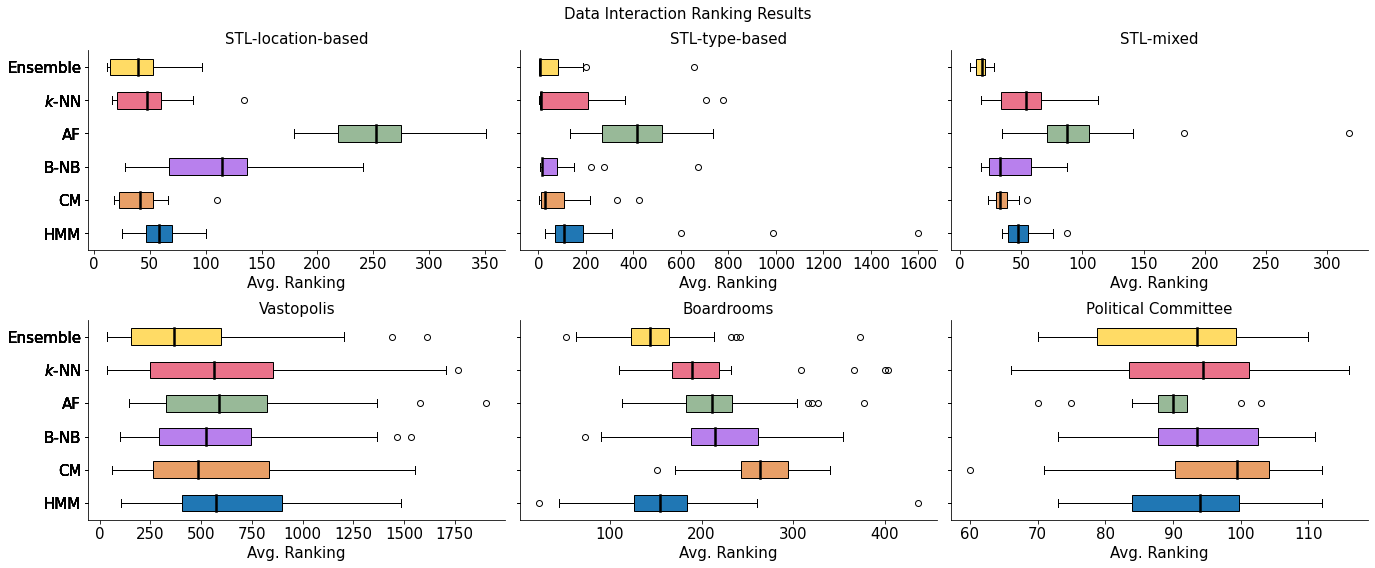

In [15]:
fig.tight_layout()
fig.savefig('../output/figs/ranking_results.png', dpi=300, bbox_inches='tight')
fig

# Bias Agree/Disagree Maximum Difference

In [ ]:
def max_diff(l):
    return np.max([x1 - x2 for x1 in l for x2 in l])

stl_map_bias_diff = pd.DataFrame()
for i, row in stl_map_results_hmm.iterrows():
    biases_this_session = pd.DataFrame()
    biases_this_session['hmm_x___y'] = stl_map_results_hmm.loc[i, 'bias-bias_x___y']
    biases_this_session['wall_x___y'] = stl_map_results_wall.loc[i, 'bias-x___y']
    #biases_this_session['ac_x___y'] = stl_map_results_ac.loc[i, 'bias-x___y']
    biases_this_session['cm_x___y'] = stl_map_results_cm.loc[i, 'bias-x___y'][1:]
    
    biases_this_session['hmm_type'] = stl_map_results_hmm.loc[i, 'bias-bias_type']
    biases_this_session['wall_type'] = stl_map_results_wall.loc[i, 'bias-type']
    #biases_this_session['ac_type'] = stl_map_results_ac.loc[i, 'bias-type']
    biases_this_session['cm_type'] = stl_map_results_cm.loc[i, 'bias-type'][1:]
    
    biases_this_session[f'max_diff_x___y'] = biases_this_session.apply(lambda row: max_diff(row[['hmm_x___y', 'wall_x___y', 'cm_x___y']]), axis=1)
    loc_bias_max_differences = biases_this_session[f'max_diff_x___y'].to_list()
    
    biases_this_session[f'max_diff_type'] = biases_this_session.apply(lambda row: max_diff(row[['hmm_type', 'wall_type', 'cm_type']]), axis=1)
    type_bias_max_differences = biases_this_session[f'max_diff_type'].to_list()  
    
    
    stl_map_bias_diff = stl_map_bias_diff.append({'task': row.task, 'participant_id': row.participant_id, 'max_diff_x___y': loc_bias_max_differences, 'max_diff_type': type_bias_max_differences}, ignore_index=True)

In [ ]:
# biases_this_session['max_diff_x___y'] = biases_this_session.apply(lambda row: max_diff(row[['hmm_x___y', 'wall_x___y', 'ac_x___y', 'cm_x___y']]), axis=1)
# biases_this_session['max_diff_type'] = biases_this_session.apply(lambda row: max_diff(row[['hmm_type', 'wall_type', 'ac_type', 'cm_type']]), axis=1)

biases_this_session['max_diff_x___y'] = biases_this_session.apply(lambda row: max_diff(row[['hmm_x___y', 'wall_x___y', 'cm_x___y']]), axis=1)
biases_this_session['max_diff_type'] = biases_this_session.apply(lambda row: max_diff(row[['hmm_type', 'wall_type', 'cm_type']]), axis=1)

In [ ]:
# Comparing bias with Wall, Competing Models and HMM
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(4*6.4, 4.8))
plt.rcParams.update({'font.size': 15, 'axes.titlesize': 15, 'axes.labelsize': 15, 'xtick.labelsize':12, 'xtick.labelsize':12})
for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.set(xlabel='Interactions Observed', ylabel='Disagreement (Less is Better)')
    ax.set_ylim((0, 1.05))
#     ax.set_xlim((2, 12))

for ai, t in enumerate(['geo-based', 'type-based', 'mixed']):
    max_bias_diff_over_time_loc = pd.DataFrame()
    max_bias_diff_over_time_type = pd.DataFrame()
    for i, row in stl_map_bias_diff[stl_map_bias_diff.task == t].iterrows():
        temp_df = pd.DataFrame()
        temp_df[row['participant_id']] = row['max_diff_x___y']
        max_bias_diff_over_time_loc = pd.concat([max_bias_diff_over_time_loc, temp_df], axis=1, ignore_index=True)
        
        temp_df = pd.DataFrame()
        temp_df[row['participant_id']] = row['max_diff_type']
        max_bias_diff_over_time_type = pd.concat([max_bias_diff_over_time_type, temp_df], axis=1, ignore_index=True)
        
        
    sems_loc = max_bias_diff_over_time_loc.std(axis=1) / np.sqrt(max_bias_diff_over_time_loc.count(axis=1))
    mean_loc = max_bias_diff_over_time_loc.mean(axis=1)
    
    sems_type = max_bias_diff_over_time_type.std(axis=1) / np.sqrt(max_bias_diff_over_time_type.count(axis=1))
    mean_type = max_bias_diff_over_time_type.mean(axis=1)
    
    
    mean_loc.plot(ax=axs[ai], title=f'Aggregate Bias Detection for {t} Task', label='Location', color='#1F77B4')
    mean_type.plot(ax=axs[ai], title=f'Aggregate Bias Detection for {t} Task', label='Type', color='#d95f02')
    
    axs[ai].fill_between(list(range(len(mean_loc))), mean_loc-2*sems_loc,mean_loc+2*sems_loc, color='#1F77B4', alpha=0.3, zorder=100)
    axs[ai].fill_between(list(range(len(mean_type))), mean_type-2*sems_type,mean_type+2*sems_type, color='#d95f02', alpha=0.3, zorder=100)

    axs[0].legend()

In [ ]:
# Averaging user bias at each interaction STL
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(3*6.4, 4.8))
sns.set_theme(style="white")
plt.rcParams.update({'font.size': 15, 'axes.titlesize': 15, 'axes.labelsize': 15, 'xtick.labelsize':12, 'xtick.labelsize':12})

vmin = -1
vmax = 1
bias_metric_per_task_hmm = {'geo-based': 'bias-bias_x___y', 'type-based': 'bias-bias_type', 'mixed': 'bias-mixed'}
bias_metric_per_task_cm = {'geo-based': 'bias-x___y', 'type-based': 'bias-type', 'mixed': 'posterior-competing_model__x___y___type'}
bias_metric_per_task_wall = {'geo-based': 'bias-x___y', 'type-based': 'bias-type', 'mixed': 'bias-mixed'}
bias_metric_per_task_ac = {'geo-based': 'bias-x___y', 'type-based': 'bias-type', 'mixed': 'bias-mixed'}

for ai, t in enumerate(['geo-based', 'type-based', 'mixed']):
    average_bias_over_time = pd.DataFrame()
    bias_over_time_hmm = pd.DataFrame()
    bias_over_time_cm = pd.DataFrame()
    bias_over_time_wall = pd.DataFrame()
    bias_over_time_ac = pd.DataFrame()
    for i, row in stl_map_results_ac[stl_map_results_ac.task == t].iterrows():
        temp_df = pd.DataFrame()
        temp_df[row['participant_id']] = row[bias_metric_per_task_ac[t]]
        bias_over_time_ac = pd.concat([bias_over_time_ac, temp_df], axis=1, ignore_index=True)
    for i, row in stl_map_results_hmm[stl_map_results_hmm.task == t].iterrows():
        temp_df = pd.DataFrame()
        temp_df[row['participant_id']] = row[bias_metric_per_task_hmm[t]]
        bias_over_time_hmm = pd.concat([bias_over_time_hmm, temp_df], axis=1, ignore_index=True)
    for i, row in stl_map_results_cm[stl_map_results_cm.task == t].iterrows():
        temp_df = pd.DataFrame()
        temp_df[row['participant_id']] = row[bias_metric_per_task_cm[t]]
        bias_over_time_cm = pd.concat([bias_over_time_cm, temp_df], axis=1, ignore_index=True)
    for i, row in stl_map_results_wall[stl_map_results_wall.task == t].iterrows():
        temp_df = pd.DataFrame()
        temp_df[row['participant_id']] = row[bias_metric_per_task_wall[t]]
        bias_over_time_wall = pd.concat([bias_over_time_wall, temp_df], axis=1, ignore_index=True)
        
    average_bias_over_time['Hidden Markov Model'] = bias_over_time_hmm.mean(axis=1)
    average_bias_over_time['Competing Models'] = bias_over_time_cm.mean(axis=1)
    average_bias_over_time['Wall'] = bias_over_time_wall.mean(axis=1)
    average_bias_over_time['Adaptive Contextualization'] = bias_over_time_ac.mean(axis=1)
    cormat = average_bias_over_time.corr()
    mask = np.triu(np.ones_like(cormat, dtype=bool), k=1)
    cmap = sns.diverging_palette(10, 230, as_cmap=True)
    if ai == 2:
        heat_map = sns.heatmap(ax=axs[ai], annot=True, data = cormat, vmin=vmin, vmax=vmax, mask=mask, cmap=cmap)
    else:
        heat_map = sns.heatmap(ax=axs[ai], annot=True, data = cormat, vmin=vmin, vmax=vmax, cbar=False, mask=mask, cmap=cmap)
    heat_map.set_xticklabels(heat_map.get_xticklabels(), rotation=45)
    axs[ai].set_title(f'Aggregate Bias Agreement for {t} task')
fig.tight_layout()

In [ ]:
# All interaction for each user over time STL
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(3*6.4, 4.8))
plt.rcParams.update({'font.size': 15, 'axes.titlesize': 15, 'axes.labelsize': 15, 'xtick.labelsize':12, 'xtick.labelsize':12})
sns.set_theme(style="white")

bias_metric_per_task_hmm = {'geo-based': 'bias-bias_x___y', 'type-based': 'bias-bias_type', 'mixed': 'bias-mixed'}
bias_metric_per_task_cm = {'geo-based': 'bias-x___y', 'type-based': 'bias-type', 'mixed': 'posterior-competing_model__x___y___type'}
bias_metric_per_task_wall = {'geo-based': 'bias-x___y', 'type-based': 'bias-type', 'mixed': 'bias-mixed'}
bias_metric_per_task_ac = {'geo-based': 'bias-x___y', 'type-based': 'bias-type', 'mixed': 'bias-mixed'}

vmin = -1
vmax = 1
for ai, t in enumerate(['geo-based', 'type-based', 'mixed']):
    bias_over_time = pd.DataFrame()
    bias_over_time_hmm = pd.DataFrame()
    bias_over_time_cm = pd.DataFrame()
    bias_over_time_wall = pd.DataFrame()
    bias_over_time_ac = pd.DataFrame()
    for i, row in stl_map_results_ac[stl_map_results_ac.task == t].iterrows():
        temp_df = pd.DataFrame()
        temp_df[row['participant_id']] = row[bias_metric_per_task_ac[t]]
        bias_over_time_ac = pd.concat([bias_over_time_ac, temp_df], axis=1, ignore_index=True)
    for i, row in stl_map_results_hmm[stl_map_results_hmm.task == t].iterrows():
        temp_df = pd.DataFrame()
        temp_df[row['participant_id']] = row[bias_metric_per_task_hmm[t]]
        bias_over_time_hmm = pd.concat([bias_over_time_hmm, temp_df], axis=1, ignore_index=True)
    for i, row in stl_map_results_cm[stl_map_results_cm.task == t].iterrows():
        temp_df = pd.DataFrame()
        temp_df[row['participant_id']] = row[bias_metric_per_task_cm[t]]
        bias_over_time_cm = pd.concat([bias_over_time_cm, temp_df], axis=1, ignore_index=True)
    for i, row in stl_map_results_wall[stl_map_results_wall.task == t].iterrows():
        temp_df = pd.DataFrame()
        temp_df[row['participant_id']] = row[bias_metric_per_task_wall[t]]
        bias_over_time_wall = pd.concat([bias_over_time_wall, temp_df], axis=1, ignore_index=True)
        
    bias_over_time['Hidden Markov Model'] = bias_over_time_hmm.stack().reset_index()[0].astype(float)
    bias_over_time['Competing Models'] = bias_over_time_cm.stack().reset_index()[0].astype(float)
    bias_over_time['Wall'] = bias_over_time_wall.stack().reset_index()[0].astype(float)
    bias_over_time['Adaptive Contextualization'] = bias_over_time_ac.stack().reset_index()[0].astype(float)
    cormat = bias_over_time.corr()
    mask = np.triu(np.ones_like(cormat, dtype=bool), k=1)
    cmap = sns.diverging_palette(10, 230, as_cmap=True)
    if ai == 2:
        heat_map = sns.heatmap(ax=axs[ai], annot=True, data = cormat, vmin=vmin, vmax=vmax, mask=mask, cmap=cmap)
    else:
        heat_map = sns.heatmap(ax=axs[ai], annot=True, data = cormat, vmin=vmin, vmax=vmax, cbar=False, mask=mask, cmap=cmap)
    heat_map.set_xticklabels(heat_map.get_xticklabels(), rotation=45)
    axs[ai].set_title(f'Bias Agreement for {t} task')
fig.tight_layout()

In [ ]:
# Averaging user bias at each interaction VAST

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(1.5*6.4, 4.8))
sns.set_theme(style="white")
plt.rcParams.update({'axes.titlesize': 15, 'axes.labelsize': 15, 'xtick.labelsize':12, 'xtick.labelsize':12})

bias_metric_per_task_hmm = {'location-based': 'bias-bias_latitude___longitude', 'topic-based': 'bias-bias_topic'}
bias_metric_per_task_cm = {'location-based': 'bias-latitude___longitude', 'topic-based': 'bias-topic'}
bias_metric_per_task_wall = {'location-based': 'bias-latitude___longitude', 'topic-based': 'bias-topic'}
bias_metric_per_task_ac = {'location-based': 'bias-latitude___longitude', 'topic-based': 'bias-topic'}

vmin = -1
vmax = 1
t = 'control'
for ai, attr in enumerate(['location-based', 'topic-based']):
    average_bias_over_time = pd.DataFrame()
    bias_over_time_cm = pd.DataFrame()
    bias_over_time_wall = pd.DataFrame()
    bias_over_time_hmm = pd.DataFrame()
    bias_over_time_ac = pd.DataFrame()
    for i, row in vast_results_ac[vast_results_ac.task == t].iterrows():
        temp_df = pd.DataFrame()
        temp_df[row['participant_id']] = row[bias_metric_per_task_ac[attr]]
        bias_over_time_ac = pd.concat([bias_over_time_ac, temp_df], axis=1, ignore_index=True)
    for i, row in vast_results_hmm[vast_results_hmm.task == t].iterrows():
        temp_df = pd.DataFrame()
        temp_df[row['participant_id']] = row[bias_metric_per_task_hmm[attr]]
        bias_over_time_hmm = pd.concat([bias_over_time_hmm, temp_df], axis=1, ignore_index=True)
    for i, row in vast_results_cm[vast_results_cm.task == t].iterrows():
        temp_df = pd.DataFrame()
        temp_df[row['participant_id']] = row[bias_metric_per_task_cm[attr]]
        bias_over_time_cm = pd.concat([bias_over_time_cm, temp_df], axis=1, ignore_index=True)
    for i, row in vast_results_wall[vast_results_wall.task == t].iterrows():
        temp_df = pd.DataFrame()
        temp_df[row['participant_id']] = row[bias_metric_per_task_wall[attr]]
        bias_over_time_wall = pd.concat([bias_over_time_wall, temp_df], axis=1, ignore_index=True)

    average_bias_over_time['Hidden Markov Model'] = bias_over_time_hmm.mean(axis=1)
    average_bias_over_time['Competing Models'] = bias_over_time_cm.mean(axis=1)
    average_bias_over_time['Wall'] = bias_over_time_wall.mean(axis=1)
    average_bias_over_time['Adaptive Contextualization'] = bias_over_time_ac.mean(axis=1)
    cormat = average_bias_over_time.corr()
    mask = np.triu(np.ones_like(cormat, dtype=bool), k=1)
    cmap = sns.diverging_palette(10, 230, as_cmap=True)
    if ai == 1:
        heat_map = sns.heatmap(ax=axs[ai], annot=True, data = cormat, vmin=vmin, vmax=vmax, mask=mask, cmap=cmap)
    else:
        heat_map = sns.heatmap(ax=axs[ai], annot=True, data = cormat, vmin=vmin, vmax=vmax, cbar=False, mask=mask, cmap=cmap)
    heat_map.set_xticklabels(heat_map.get_xticklabels(), rotation=45)
    axs[ai].set_title(f'Aggregate Bias Agreement for {attr}')
fig.tight_layout()

In [ ]:
# All interaction for each user over time VAST

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(1.5*6.4, 4.8))
sns.set_theme(style="white")
plt.rcParams.update({'axes.titlesize': 15, 'axes.labelsize': 15, 'xtick.labelsize':12, 'xtick.labelsize':12})

bias_metric_per_task_hmm = {'location-based': 'bias-bias_latitude___longitude', 'topic-based': 'bias-bias_topic'}
bias_metric_per_task_cm = {'location-based': 'bias-latitude___longitude', 'topic-based': 'bias-topic'}
bias_metric_per_task_wall = {'location-based': 'bias-latitude___longitude', 'topic-based': 'bias-topic'}
bias_metric_per_task_ac = {'location-based': 'bias-latitude___longitude', 'topic-based': 'bias-topic'}

vmin = -1
vmax = 1
t = 'control'
for ai, attr_name in enumerate(['Location', 'Topic']):
    attr = f'{attr_name.lower()}-based'
    bias_over_time = pd.DataFrame()
    bias_over_time_cm = pd.DataFrame()
    bias_over_time_wall = pd.DataFrame()
    bias_over_time_hmm = pd.DataFrame()
    bias_over_time_ac = pd.DataFrame()
    for i, row in vast_results_ac[vast_results_ac.task == t].iterrows():
        temp_df = pd.DataFrame()
        temp_df[row['participant_id']] = row[bias_metric_per_task_ac[attr]]
        bias_over_time_ac = pd.concat([bias_over_time_ac, temp_df], axis=1, ignore_index=True)
    for i, row in vast_results_hmm[vast_results_hmm.task == t].iterrows():
        temp_df = pd.DataFrame()
        temp_df[row['participant_id']] = row[bias_metric_per_task_hmm[attr]]
        bias_over_time_hmm = pd.concat([bias_over_time_hmm, temp_df], axis=1, ignore_index=True)
    for i, row in vast_results_cm[vast_results_cm.task == t].iterrows():
        temp_df = pd.DataFrame()
        temp_df[row['participant_id']] = row[bias_metric_per_task_cm[attr]]
        bias_over_time_cm = pd.concat([bias_over_time_cm, temp_df], axis=1, ignore_index=True)
    for i, row in vast_results_wall[vast_results_wall.task == t].iterrows():
        temp_df = pd.DataFrame()
        temp_df[row['participant_id']] = row[bias_metric_per_task_wall[attr]]
        bias_over_time_wall = pd.concat([bias_over_time_wall, temp_df], axis=1, ignore_index=True)
        
    bias_over_time['HMM'] = bias_over_time_hmm.stack().reset_index()[0].astype(float)
    bias_over_time['CM'] = bias_over_time_cm.stack().reset_index()[0].astype(float)
    bias_over_time['AD'] = bias_over_time_wall.stack().reset_index()[0].astype(float)
    bias_over_time['AC'] = bias_over_time_ac.stack().reset_index()[0].astype(float)
    cormat = bias_over_time.corr()
    mask = np.triu(np.ones_like(cormat, dtype=bool), k=1)
    cmap = sns.diverging_palette(10, 230, as_cmap=True)
    if ai == 1:
        heat_map = sns.heatmap(ax=axs[ai], annot=True, data = cormat, vmin=vmin, vmax=vmax, mask=mask, cmap=cmap)
    else:
        heat_map = sns.heatmap(ax=axs[ai], annot=True, data = cormat, vmin=vmin, vmax=vmax, cbar=False, mask=mask, cmap=cmap)
    heat_map.set_xticklabels(heat_map.get_xticklabels(), rotation=0)
    axs[ai].set_title(f'{attr_name}')
fig.suptitle('Vastopolis Bias Metric Correlation')
fig.tight_layout()

fig.savefig('../output/figs/vast_bias_corr.png', dpi=300, bbox_inches='tight')

In [ ]:
# All interaction for each user over time STL-1

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(1.5*6.4, 4.8))
sns.set_theme(style="white")
plt.rcParams.update({'axes.titlesize': 15, 'axes.labelsize': 15, 'xtick.labelsize':12, 'xtick.labelsize':12})

bias_metric_per_task_hmm = {'location-based': 'bias-bias_x___y', 'type-based': 'bias-bias_type'}
bias_metric_per_task_cm = {'location-based': 'bias-x___y', 'type-based': 'bias-type'}
bias_metric_per_task_wall = {'location-based': 'bias-x___y', 'type-based': 'bias-type'}
bias_metric_per_task_ac = {'location-based': 'bias-x___y', 'type-based': 'bias-type'}

vmin = -1
vmax = 1
t = 'geo-based'
for ai, attr_name in enumerate(['Location', 'Type']):
    attr = f'{attr_name.lower()}-based'
    bias_over_time = pd.DataFrame()
    bias_over_time_cm = pd.DataFrame()
    bias_over_time_wall = pd.DataFrame()
    bias_over_time_hmm = pd.DataFrame()
    bias_over_time_ac = pd.DataFrame()
    for i, row in stl_map_results_ac[stl_map_results_ac.task == t].iterrows():
        temp_df = pd.DataFrame()
        temp_df[row['participant_id']] = row[bias_metric_per_task_ac[attr]]
        bias_over_time_ac = pd.concat([bias_over_time_ac, temp_df], axis=1, ignore_index=True)
    for i, row in stl_map_results_hmm[stl_map_results_hmm.task == t].iterrows():
        temp_df = pd.DataFrame()
        temp_df[row['participant_id']] = row[bias_metric_per_task_hmm[attr]]
        bias_over_time_hmm = pd.concat([bias_over_time_hmm, temp_df], axis=1, ignore_index=True)
    for i, row in stl_map_results_cm[stl_map_results_cm.task == t].iterrows():
        temp_df = pd.DataFrame()
        temp_df[row['participant_id']] = row[bias_metric_per_task_cm[attr]]
        bias_over_time_cm = pd.concat([bias_over_time_cm, temp_df], axis=1, ignore_index=True)
    for i, row in stl_map_results_wall[stl_map_results_wall.task == t].iterrows():
        temp_df = pd.DataFrame()
        temp_df[row['participant_id']] = row[bias_metric_per_task_wall[attr]]
        bias_over_time_wall = pd.concat([bias_over_time_wall, temp_df], axis=1, ignore_index=True)
        
    bias_over_time['HMM'] = bias_over_time_hmm.stack().reset_index()[0].astype(float)
    bias_over_time['CM'] = bias_over_time_cm.stack().reset_index()[0].astype(float)
    bias_over_time['AD'] = bias_over_time_wall.stack().reset_index()[0].astype(float)
    bias_over_time['AC'] = bias_over_time_ac.stack().reset_index()[0].astype(float)
    cormat = bias_over_time.corr()
    mask = np.triu(np.ones_like(cormat, dtype=bool), k=1)
    cmap = sns.diverging_palette(10, 230, as_cmap=True)
    if ai == 1:
        heat_map = sns.heatmap(ax=axs[ai], annot=True, data = cormat, vmin=vmin, vmax=vmax, mask=mask, cmap=cmap)
    else:
        heat_map = sns.heatmap(ax=axs[ai], annot=True, data = cormat, vmin=vmin, vmax=vmax, cbar=False, mask=mask, cmap=cmap)
    heat_map.set_xticklabels(heat_map.get_xticklabels(), rotation=0)
    axs[ai].set_title(f'{attr_name}')
fig.suptitle('STL-location-based Bias Metric Correlation')
fig.tight_layout()
fig.savefig('../output/figs/stl_loc_bias_corr.png', dpi=300, bbox_inches='tight')

In [ ]:
# All interaction for each user over time STL-1

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(1.5*6.4, 4.8))
sns.set_theme(style="white")
plt.rcParams.update({'axes.titlesize': 15, 'axes.labelsize': 15, 'xtick.labelsize':12, 'xtick.labelsize':12})

bias_metric_per_task_hmm = {'location-based': 'bias-bias_x___y', 'type-based': 'bias-bias_type'}
bias_metric_per_task_cm = {'location-based': 'bias-x___y', 'type-based': 'bias-type'}
bias_metric_per_task_wall = {'location-based': 'bias-x___y', 'type-based': 'bias-type'}
bias_metric_per_task_ac = {'location-based': 'bias-x___y', 'type-based': 'bias-type'}

vmin = -1
vmax = 1
t = 'type-based'
for ai, attr_name in enumerate(['Location', 'Type']):
    attr = f'{attr_name.lower()}-based'
    bias_over_time = pd.DataFrame()
    bias_over_time_cm = pd.DataFrame()
    bias_over_time_wall = pd.DataFrame()
    bias_over_time_hmm = pd.DataFrame()
    bias_over_time_ac = pd.DataFrame()
    for i, row in stl_map_results_ac[stl_map_results_ac.task == t].iterrows():
        temp_df = pd.DataFrame()
        temp_df[row['participant_id']] = row[bias_metric_per_task_ac[attr]]
        bias_over_time_ac = pd.concat([bias_over_time_ac, temp_df], axis=1, ignore_index=True)
    for i, row in stl_map_results_hmm[stl_map_results_hmm.task == t].iterrows():
        temp_df = pd.DataFrame()
        temp_df[row['participant_id']] = row[bias_metric_per_task_hmm[attr]]
        bias_over_time_hmm = pd.concat([bias_over_time_hmm, temp_df], axis=1, ignore_index=True)
    for i, row in stl_map_results_cm[stl_map_results_cm.task == t].iterrows():
        temp_df = pd.DataFrame()
        temp_df[row['participant_id']] = row[bias_metric_per_task_cm[attr]]
        bias_over_time_cm = pd.concat([bias_over_time_cm, temp_df], axis=1, ignore_index=True)
    for i, row in stl_map_results_wall[stl_map_results_wall.task == t].iterrows():
        temp_df = pd.DataFrame()
        temp_df[row['participant_id']] = row[bias_metric_per_task_wall[attr]]
        bias_over_time_wall = pd.concat([bias_over_time_wall, temp_df], axis=1, ignore_index=True)
        
    bias_over_time['HMM'] = bias_over_time_hmm.stack().reset_index()[0].astype(float)
    bias_over_time['CM'] = bias_over_time_cm.stack().reset_index()[0].astype(float)
    bias_over_time['AD'] = bias_over_time_wall.stack().reset_index()[0].astype(float)
    bias_over_time['AC'] = bias_over_time_ac.stack().reset_index()[0].astype(float)
    cormat = bias_over_time.corr()
    mask = np.triu(np.ones_like(cormat, dtype=bool), k=1)
    cmap = sns.diverging_palette(10, 230, as_cmap=True)
    if ai == 1:
        heat_map = sns.heatmap(ax=axs[ai], annot=True, data = cormat, vmin=vmin, vmax=vmax, mask=mask, cmap=cmap)
    else:
        heat_map = sns.heatmap(ax=axs[ai], annot=True, data = cormat, vmin=vmin, vmax=vmax, cbar=False, mask=mask, cmap=cmap)
    heat_map.set_xticklabels(heat_map.get_xticklabels(), rotation=0)
    axs[ai].set_title(f'{attr_name}')
fig.suptitle('STL-type-based Bias Metric Correlation')
fig.tight_layout()
fig.savefig('../output/figs/stl_type_bias_corr.png', dpi=300, bbox_inches='tight')

In [ ]:
# All interaction for each user over time STL-1

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(1.5*6.4, 4.8))
sns.set_theme(style="white")
plt.rcParams.update({'axes.titlesize': 15, 'axes.labelsize': 15, 'xtick.labelsize':12, 'xtick.labelsize':12})

bias_metric_per_task_hmm = {'location-based': 'bias-bias_x___y', 'type-based': 'bias-bias_type'}
bias_metric_per_task_cm = {'location-based': 'bias-x___y', 'type-based': 'bias-type'}
bias_metric_per_task_wall = {'location-based': 'bias-x___y', 'type-based': 'bias-type'}
bias_metric_per_task_ac = {'location-based': 'bias-x___y', 'type-based': 'bias-type'}

vmin = -1
vmax = 1
t = 'mixed'
for ai, attr_name in enumerate(['Location', 'Type']):
    attr = f'{attr_name.lower()}-based'
    bias_over_time = pd.DataFrame()
    bias_over_time_cm = pd.DataFrame()
    bias_over_time_wall = pd.DataFrame()
    bias_over_time_hmm = pd.DataFrame()
    bias_over_time_ac = pd.DataFrame()
    for i, row in stl_map_results_ac[stl_map_results_ac.task == t].iterrows():
        temp_df = pd.DataFrame()
        temp_df[row['participant_id']] = row[bias_metric_per_task_ac[attr]]
        bias_over_time_ac = pd.concat([bias_over_time_ac, temp_df], axis=1, ignore_index=True)
    for i, row in stl_map_results_hmm[stl_map_results_hmm.task == t].iterrows():
        temp_df = pd.DataFrame()
        temp_df[row['participant_id']] = row[bias_metric_per_task_hmm[attr]]
        bias_over_time_hmm = pd.concat([bias_over_time_hmm, temp_df], axis=1, ignore_index=True)
    for i, row in stl_map_results_cm[stl_map_results_cm.task == t].iterrows():
        temp_df = pd.DataFrame()
        temp_df[row['participant_id']] = row[bias_metric_per_task_cm[attr]]
        bias_over_time_cm = pd.concat([bias_over_time_cm, temp_df], axis=1, ignore_index=True)
    for i, row in stl_map_results_wall[stl_map_results_wall.task == t].iterrows():
        temp_df = pd.DataFrame()
        temp_df[row['participant_id']] = row[bias_metric_per_task_wall[attr]]
        bias_over_time_wall = pd.concat([bias_over_time_wall, temp_df], axis=1, ignore_index=True)
        
    bias_over_time['HMM'] = bias_over_time_hmm.stack().reset_index()[0].astype(float)
    bias_over_time['CM'] = bias_over_time_cm.stack().reset_index()[0].astype(float)
    bias_over_time['AD'] = bias_over_time_wall.stack().reset_index()[0].astype(float)
    bias_over_time['AC'] = bias_over_time_ac.stack().reset_index()[0].astype(float)
    cormat = bias_over_time.corr()
    mask = np.triu(np.ones_like(cormat, dtype=bool), k=1)
    cmap = sns.diverging_palette(10, 230, as_cmap=True)
    if ai == 1:
        heat_map = sns.heatmap(ax=axs[ai], annot=True, data = cormat, vmin=vmin, vmax=vmax, mask=mask, cmap=cmap)
    else:
        heat_map = sns.heatmap(ax=axs[ai], annot=True, data = cormat, vmin=vmin, vmax=vmax, cbar=False, mask=mask, cmap=cmap)
    heat_map.set_xticklabels(heat_map.get_xticklabels(), rotation=0)
    axs[ai].set_title(f'{attr_name}')
fig.suptitle('STL-mixed Bias Metric Correlation')
fig.tight_layout()
fig.savefig('../output/figs/stl_mixed_bias_corr.png', dpi=300, bbox_inches='tight')

# Top Ranking Bias Over Time

In [12]:
# Political
political_interaction_data['interaction_session'] = political_interaction_data.apply(lambda row: ast.literal_eval(str(row.interaction_session)), axis=1)
political_interaction_data['interaction_type'] = political_interaction_data.apply(lambda row: ast.literal_eval(str(row.interaction_type)), axis=1)

bias_metric_per_task = {'party': 'bias-party', 'gender': 'bias-gender', 'occupation':'bias-occupation',
                       'age': 'bias-age', 'political_experience': 'bias-political_experience',
                       'policy_strength_ban_abortion_after_6_weeks': 'bias-policy_strength_ban_abortion_after_6_weeks',
                       'policy_strength_legalize_medical_marijuana':'bias-policy_strength_legalize_medical_marijuana',
                        'policy_strength_increase_medicare_funding': 'bias-policy_strength_increase_medicare_funding',
                       'policy_strength_ban_alcohol_sales_sundays': 'bias-policy_strength_ban_alcohol_sales_sundays'}

bias_metric_per_task_hmm = {'party': 'bias-bias_party', 'gender': 'bias-bias_gender', 'occupation':'bias-bias_occupation',
                       'age': 'bias-bias_age', 'political_experience': 'bias-bias_political_experience',
                       'policy_strength_ban_abortion_after_6_weeks': 'bias-bias_policy_strength_ban_abortion_after_6_weeks',
                       'policy_strength_legalize_medical_marijuana':'bias-bias_policy_strength_legalize_medical_marijuana',
                        'policy_strength_increase_medicare_funding': 'bias-bias_policy_strength_increase_medicare_funding',
                       'policy_strength_ban_alcohol_sales_sundays': 'bias-bias_policy_strength_ban_alcohol_sales_sundays'}

bias_metric_per_task_ac = {'party': 'bias-party', 'gender': 'bias-gender', 'occupation':'bias-occupation',
                       'age': 'bias-age_disc', 'political_experience': 'bias-political_experience_disc',
                       'policy_strength_ban_abortion_after_6_weeks': 'bias-policy_strength_ban_abortion_after_6_weeks_disc',
                       'policy_strength_legalize_medical_marijuana':'bias-policy_strength_legalize_medical_marijuana_disc',
                        'policy_strength_increase_medicare_funding': 'bias-policy_strength_increase_medicare_funding_disc',
                       'policy_strength_ban_alcohol_sales_sundays': 'bias-policy_strength_ban_alcohol_sales_sundays_disc'}

shorten_col = ['policy_strength_legalize_medical_marijuana', 'policy_strength_ban_abortion_after_6_weeks',
                   'policy_strength_increase_medicare_funding', 'policy_strength_ban_alcohol_sales_sundays']

shorten_col_vals = {'policy_strength_legalize_medical_marijuana': 'marijuana',
              'policy_strength_ban_abortion_after_6_weeks': 'abortion',
              'policy_strength_increase_medicare_funding': 'medicare',
              'policy_strength_ban_alcohol_sales_sundays': 'alcohol'}
participant_names = ['Alfa', 'Bravo', 'Charlie', 'Delta', 'Echo', 'Foxtrot', 'Golf', 'Hotel', 'India', 
                     'Juliett', 'Kilo', 'Lima']

def user_bias_over_time(user, results, bias_metric_names, alg, interaction_data, index):
    user_top_bias = pd.DataFrame()
    attribute_list = []
    session_len = len(interaction_data.loc[interaction_data.user == user, 'interaction_session'].values[0])
    user_bias_data = results[results.participant_id == user]
    user_name = participant_names[index]
    for i in range(session_len):
        if i > 0:
            current_max = {'attribute': '', 'bias': 0}
            for attr in bias_metric_names.values():
                attr_clean = [k for k,v in bias_metric_names.items() if v == attr][0]
                if attr_clean in shorten_col:
                    attr_clean = shorten_col_vals[attr_clean]
                current_bias =  float(user_bias_data[attr].values[0][i-1])
                if current_max['bias'] < current_bias:
                    diff = current_bias - current_max['bias']
                    if diff > 0.01:
                        current_max['attribute'] = attr_clean
                        current_max['bias'] = current_bias
                    else:
                        random_top = random.choice([current_max['attribute'], attr_clean])
                        if(random_top == attr_clean):
                            current_max['bias'] = current_bias
                            current_max['attribute'] = random_top
            if alg == 'AD':
                alg = 'AD    '
            user_top_bias = pd.concat([user_top_bias, pd.DataFrame({'user': user_name, 'alg': alg,'start': [i],
                                        'stop': [i + 1], 'top_bias': [current_max['attribute']],
                                        'bias_value': [round(current_max['bias'], 2)]})])
    return user_top_bias.reset_index(drop=True)
            
user_list = political_interaction_data['user'].unique()
all_user_sessions = pd.DataFrame()

for i, user in enumerate(user_list):
    df = user_bias_over_time(user, political_results_wall, bias_metric_per_task, 'AD', political_interaction_data,i)
    df_hmm = user_bias_over_time(user, political_results_hmm, bias_metric_per_task_hmm, 'HMM', political_interaction_data,i)
    df_cm = user_bias_over_time(user, political_results_cm, bias_metric_per_task, 'CM', political_interaction_data,i)
    df_ac = user_bias_over_time(user, political_results_ac, bias_metric_per_task_ac, 'AC', political_interaction_data,i)
    df_ensemble = user_bias_over_time(user, political_results_ensemble_bias, bias_metric_per_task, 'ENS', political_interaction_data, i)
    combined_user = pd.concat([df, df_hmm, df_ac, df_cm, df_ensemble])
    all_user_sessions = pd.concat([all_user_sessions, combined_user])
    
all_user_sessions['delta'] = all_user_sessions['stop'] - all_user_sessions['start']
# colors = px.colors.qualitative.Plotly + px.colors.qualitative.Safe + px.colors.qualitative.Antique
colors = px.colors.qualitative.Plotly + px.colors.qualitative.Dark24
fig = px.timeline(all_user_sessions, x_start='start', x_end='stop', y='alg', color='top_bias', text='bias_value',
                  facet_col='user', facet_col_wrap = 4,
                  title = 'Top Ranking Bias During Exploration of Political Committee Data',
                 labels = {'alg':''}, facet_row_spacing=0.07, width=1500, height=700)

fig.for_each_xaxis(lambda xaxis: xaxis.update(type='linear'))

for d in fig.data:
    x_array = len(d.x)
    d.x = [1] * x_array

fig.update_xaxes(
    nticks= 8,
    range= [1,16],
    title_font=dict(size=12)
)
fig.update_yaxes(categoryorder='array', categoryarray=['AD    ', 'HMM', 'AC', 'CM', 'ENS'])

font_size = 20
fig.update_xaxes(title_text = 'Interactions Observed', title_font=dict(size=font_size), row=1, col=1)
fig.update_xaxes(title_text = 'Interactions Observed', title_font=dict(size=font_size), row=1, col=2)
fig.update_xaxes(title_text = 'Interactions Observed', title_font=dict(size=font_size), row=1, col=3)
fig.update_xaxes(title_text = 'Interactions Observed', title_font=dict(size=font_size), row=1, col=4)


fig.update_layout(
    title = dict(x=0.5, xanchor='center', yanchor='top', font_size=font_size),
    legend=dict(title = '', orientation="h", yanchor="bottom", y=-0.35, xanchor="center", x=0.5),
    font=dict(color='black', size=font_size)
)

fig.for_each_trace(
    lambda trace: trace.update(marker_opacity = trace.text)
)
# fig.update_yaxes(automargin=True)
fig['layout']['yaxis']['autorange'] = True
fig.update_traces(textfont_size=4, textangle=0, text='')
fig.show()
fig.write_image('../output/figs/political_user_session.png', scale=2)

In [6]:
bias_metric_per_task_hmm = {'geo-based': 'bias-bias_x___y', 'type-based': 'bias-bias_type', 'mixed': 'bias-mixed'}
bias_metric_per_task_cm = {'geo-based': 'bias-x___y', 'type-based': 'bias-type', 'mixed': 'posterior-competing_model__x___y___type'}
bias_metric_per_task_wall = {'geo-based': 'bias-x___y', 'type-based': 'bias-type', 'mixed': 'bias-mixed'}
bias_metric_per_task_ac = {'geo-based': 'bias-x___y', 'type-based': 'bias-type', 'mixed': 'bias-mixed'}

def aggregated(alg, results, bias_metric_per_task):
    all_avg_bias = pd.DataFrame()
    for ai, t in enumerate(['geo-based', 'type-based', 'mixed']):
        bias_over_time_geo = pd.DataFrame()
        bias_over_time_type = pd.DataFrame()
        bias_over_time_mixed = pd.DataFrame()
        for i, row in results[results.task == t].iterrows():
            temp_df_x_y = pd.DataFrame()
            temp_df_type = pd.DataFrame()
            temp_df_mixed = pd.DataFrame()
            temp_df_x_y[row['participant_id']] = row[bias_metric_per_task['geo-based']]
            temp_df_type[row['participant_id']] = row[bias_metric_per_task['type-based']]
            temp_df_mixed[row['participant_id']] = row[bias_metric_per_task['mixed']]
            bias_over_time_geo = pd.concat([bias_over_time_geo, temp_df_x_y], axis=1, ignore_index=True)
            bias_over_time_type = pd.concat([bias_over_time_type, temp_df_type], axis=1, ignore_index=True)
            bias_over_time_mixed = pd.concat([bias_over_time_mixed, temp_df_mixed], axis=1, ignore_index=True)
        mean_bias_geo = bias_over_time_geo.mean(axis=1).to_numpy()
        mean_bias_type = bias_over_time_type.mean(axis=1).to_numpy()
        mean_bias_mixed = bias_over_time_mixed.mean(axis=1).to_numpy()
        all_avg_bias = pd.concat([all_avg_bias,
                                  pd.DataFrame({'alg': [alg], 'task': t,
                                                'bias-x___y': [mean_bias_geo],
                                                'bias-type': [mean_bias_type],
                                                'bias-mixed': [mean_bias_mixed]})])
    return all_avg_bias
hmm_agg = aggregated('HMM', stl_map_results_hmm, bias_metric_per_task_hmm)
wall_agg = aggregated('AD', stl_map_results_wall, bias_metric_per_task_wall)
ac_agg = aggregated('AC', stl_map_results_ac, bias_metric_per_task_ac)
cm_agg = aggregated('CM', stl_map_results_cm, bias_metric_per_task_cm)
ens_agg = aggregated('ENS', stl_map_results_ensemble_bias, bias_metric_per_task_ac)
all_task_sessions = pd.concat([hmm_agg, wall_agg, cm_agg, ac_agg, ens_agg])
# all_task_sessions = pd.concat([hmm_agg, cm_agg, ac_agg])
task_list = ['geo-based', 'type-based', 'mixed']

def task_bias_over_time(task, results, alg):
    bias_metric_names = {'location-based': 'bias-x___y', 'type-based': 'bias-type'}
    task_top_bias = pd.DataFrame()
    attribute_list = []
    task_bias_data = results[results['alg'] == alg]
    session_len = len(task_bias_data.iloc[0]['bias-type']) + 1
    if alg == 'CM':
        session_len = len(task_bias_data.iloc[0]['bias-type'])
    for i in range(session_len):
        if i > 0:
            current_max = {'attribute': '', 'bias': 0}
            for attr in bias_metric_names.values():
                attr_clean = [k for k,v in bias_metric_names.items() if v == attr][0]
                current_bias =  float(task_bias_data[attr].values[0][i-1])
                diff = abs(float(current_bias - current_max['bias']))
                if current_max['bias'] < current_bias and diff >= 0.01:
                    diff = current_bias - current_max['bias']
                    current_max['attribute'] = attr_clean
                    current_max['bias'] = current_bias
                else:
                    if (diff <= 0.01):
                        current_max_str = current_max['attribute'] + ' ' + attr_clean
                        current_max_str = current_max_str.replace(' + ', ' ')
                        split_array = current_max_str.split()
                        list_max_attrs = sorted(split_array)
                        mixed_attr_title = ' + '.join([elem for elem in list_max_attrs])
                        current_max['attribute'] = mixed_attr_title
                        current_max['bias'] = current_bias * current_max['bias']
            if task == 'geo-based':
                task = 'location-based'
            if alg == 'AD':
                alg = 'AD    '
            task_top_bias = pd.concat([task_top_bias, pd.DataFrame({'task': [task], 'alg': alg, 'start': [i],
                                        'stop': [i + 1], 'top_bias': [current_max['attribute']],
                                        'bias_value': [round(current_max['bias'], 2)]})])
    return task_top_bias.reset_index(drop=True)


all_task_sessions_over_time = pd.DataFrame()
for task in task_list:
    res = all_task_sessions[all_task_sessions['task'] == task]
    df = task_bias_over_time(task, res, 'AD')
    df_hmm = task_bias_over_time(task, res, 'HMM')
    df_cm = task_bias_over_time(task, res, 'CM')
    df_ac = task_bias_over_time(task, res, 'AC')
    df_ens = task_bias_over_time(task, res, 'ENS')
    combined_task = pd.concat([df, df_hmm, df_ac, df_cm, df_ens])
#     combined_task = pd.concat([df_hmm, df_cm, df_ac])
    all_task_sessions_over_time = pd.concat([all_task_sessions_over_time, combined_task])
    
all_task_sessions_over_time['delta'] = all_task_sessions_over_time['stop'] - all_task_sessions_over_time['start']

colors = px.colors.qualitative.Plotly + px.colors.qualitative.Dark24
fig = px.timeline(all_task_sessions_over_time, x_start='start', x_end='stop', y='alg', color='top_bias', text='bias_value',
                  facet_col ='task', title = 'Top Ranking Bias During Exploration of STL Crimes Data',
                 labels = {'alg':''}, facet_row_spacing=0.04, width=1500, height=400,
                 color_discrete_sequence=colors)

fig.for_each_xaxis(lambda xaxis: xaxis.update(type='linear'))

for d in fig.data:
    x_array = len(d.x)
    d.x = [1] * x_array

fig.update_xaxes(
    nticks= 8,
    range = [1, None],
    title_font=dict(size=12)
)

font_size = 20
fig.update_xaxes(title_text = 'Interactions Observed', title_font=dict(size=font_size), row=1, col=1)
fig.update_xaxes(title_text = 'Interactions Observed', title_font=dict(size=font_size), row=1, col=2)
fig.update_xaxes(title_text = 'Interactions Observed', title_font=dict(size=font_size), row=1, col=3)

fig.update_layout(
    title = dict(x=0.5, xanchor='center', yanchor='top', font_size=font_size),
    legend=dict(title = '', orientation="h", yanchor="bottom", y=-.7, xanchor="center", x=0.5),
    font=dict(color='black', size=font_size)
)

fig.for_each_trace(
    lambda trace: trace.update(marker_opacity = trace.text)
)
fig['layout']['yaxis']['autorange'] = True
fig.update_traces(textfont_size=4, textangle=0, text='')
fig.update_xaxes(matches=None)
fig.show()
fig.write_image('../output/figs/stl_agg_session.png', scale=2)